In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Create spark session

In [2]:
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

# 2. Read in data

In [3]:
df = spark.read.csv("data/Base.csv", header=True, inferSchema=True)

# 3. Remove not needed features
From EDA we saw that we should remove: 'device_fraud_count'

In [4]:
df = df.drop("device_fraud_count")

# 3. Address class imbalance

In [5]:
# calculate the class distribution
fraud_count = df.filter(df.fraud_bool == 1).count()
no_fraud_count = df.filter(df.fraud_bool == 0).count()

total_count = fraud_count + no_fraud_count
fraud_weight = total_count / (2.0 * fraud_count)  # minority class (fraud)
legit_weight = total_count / (2.0 * no_fraud_count)  # majority class (legit)

# create a weight column
df = df.withColumn("class_weight", F.when(df.fraud_bool == 1, fraud_weight).otherwise(legit_weight))


# 4. One-hot encoding
From EDA we already know which features are cat and which ones are num. Now, from the cat, we will only one-hot encode the ones that are not binary. These are: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [6]:
cat_features = ['payment_type',
'employment_status',
'housing_status',
'source',
'device_os',
'keep_alive_session',
'foreign_request',
'has_other_cards',
'phone_mobile_valid',
'phone_home_valid',
'email_is_free',
'customer_age']

one_hot_features = ['payment_type',
'employment_status',
'housing_status',
'source',
'device_os']

num_features = ['income',
'name_email_similarity',
'prev_address_months_count',
'current_address_months_count',
'days_since_request',
'intended_balcon_amount',
'zip_count_4w',
'velocity_6h',
'velocity_24h',
'velocity_4w',
'bank_branch_count_8w',
'date_of_birth_distinct_emails_4w',
'credit_risk_score',
'bank_months_count',
'proposed_credit_limit',
'session_length_in_minutes',
'device_distinct_emails_8w',
'month']

In [7]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in one_hot_features]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in one_hot_features]
encoded_cols = [col + "_encoded" for col in one_hot_features]

# assemble all the features into a single feature vector
assembler = VectorAssembler(inputCols=num_features + encoded_cols, outputCol="features")


# 4. Training
Define model, split data, create pipeline and fit the model. 

In [8]:
# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="fraud_bool", weightCol="class_weight", featuresCol="features", maxIter=10)

# Split the dataset into train and test
train_df, test_df = df.randomSplit([0.9, 0.1], seed=42)

# Create a pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Fit the pipeline model
lr_model = pipeline.fit(train_df)

# 5. Evaluation

In [9]:
predictions = lr_model.transform(test_df)

## 5.1. AUC


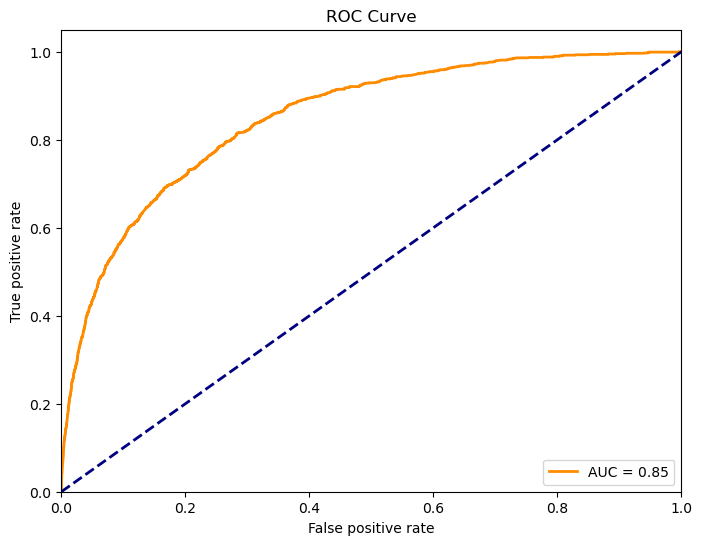

In [10]:
# Convert to Pandas for ROC curve calculations
predictions_pd = predictions.select("fraud_bool", "probability").toPandas()
predictions_pd["probability_class_1"] = predictions_pd["probability"].apply(lambda x: x[1])

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(predictions_pd["fraud_bool"], predictions_pd["probability_class_1"])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 5.2. Precision, Recall and F1

In [11]:
# Evaluate the model using precision, recall, and F1 score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9960936003982995
Recall: 0.7878013812043132
F1-Score: 0.870538154086131


## 5.3. Confusion matrix

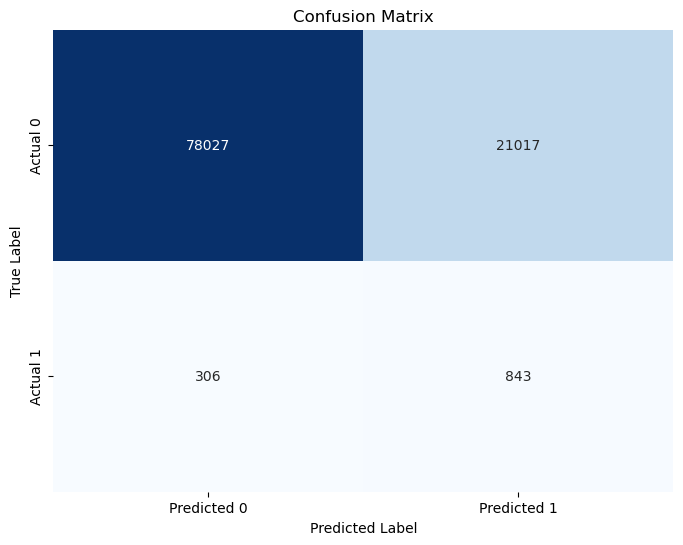

In [12]:
confusion_matrix = predictions.groupBy("fraud_bool", "prediction").count()
confusion_matrix_pd = confusion_matrix.toPandas()
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='fraud_bool', columns='prediction', values='count').fillna(0)

# Plot Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 5.4. Example of predictions

In [13]:
predictions.select("fraud_bool", "prediction", "probability").show(10, truncate=False)


+----------+----------+----------------------------------------+
|fraud_bool|prediction|probability                             |
+----------+----------+----------------------------------------+
|0         |1.0       |[0.3372925970586946,0.6627074029413054] |
|0         |1.0       |[0.22157535848592286,0.7784246415140772]|
|0         |0.0       |[0.6380950158436961,0.3619049841563039] |
|0         |1.0       |[0.37574059448060887,0.6242594055193911]|
|0         |0.0       |[0.7564022479920567,0.2435977520079433] |
|0         |0.0       |[0.9041130852291706,0.09588691477082945]|
|0         |0.0       |[0.8944351200559216,0.10556487994407837]|
|0         |0.0       |[0.6752367369119463,0.3247632630880537] |
|0         |0.0       |[0.8966904523223094,0.10330954767769063]|
|0         |0.0       |[0.7485068440300549,0.25149315596994515]|
+----------+----------+----------------------------------------+
only showing top 10 rows



## Next steps ?
- Model tuning
- Understand why predictions were wrong
- More visualizations

## 5.5 Understanding Wrong predictions
I wanna get a better idea why some of the predictions were wrong, this is not really needed since the classifiers are overal very good at predicting. But maybe there is more to learn about the dataset that could help the classification in the future. Plus it's nice to write about :)

#### Steps I want to do
- Identify misclassified samples
- See if I can find patterns in misclassified samples
- Visualize samples
- ....

In [26]:
# Get false positives and false negatives
false_positives = predictions.filter((predictions.fraud_bool == 0) & (predictions.prediction == 1))
false_negatives = predictions.filter((predictions.fraud_bool == 1) & (predictions.prediction == 0))

misclassified = predictions.filter(predictions.fraud_bool != predictions.prediction)

# misclassified.select('fraud_bool', 'prediction', 'probability', 'features').show(10)

# Show descriptive statistics of false positives and false negatives
false_positives.describe().show()
false_negatives.describe().show()

+-------+----------+-------------------+---------------------+-------------------------+----------------------------+------------------+--------------------+----------------------+------------+------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-----------------+------------------+------------------+--------------+-------------------+------------------+------------------+-------------------+---------------------+--------------------+--------+-------------------------+---------+------------------+-------------------------+------------------+------------------+------------------+-----------------------+--------------------+--------------------+------------------+----------+
|summary|fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|      customer_age|  days_since_request|intended_balcon_amount|payment_type|      zip_count_4w|        velocity_6h|      ve